## Косарский Иван, ПМИ-3

## Нейронные сети. Автоэнкодеры

### Необходимые зависимости

In [92]:
import pandas as pd
import numpy as np
import pickle

from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

### Загрузка даннах

In [93]:
df = pd.read_csv('transaction_dataset.csv')

df.head()

,Unnamed: 0,Index,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,max value received,avg val received,min val sent,max val sent,avg val sent,min value sent to contract,max val sent to contract,avg value sent to contract,total transactions (including tnx to create contract,total Ether sent,total ether received,total ether sent contracts,total ether balance,Total ERC20 tnxs,ERC20 total Ether received,ERC20 total ether sent,ERC20 total Ether sent contract,ERC20 uniq sent addr,ERC20 uniq rec addr,ERC20 uniq sent addr.1,ERC20 uniq rec contract addr,ERC20 avg time between sent tnx,ERC20 avg time between rec tnx,ERC20 avg time between rec 2 tnx,ERC20 avg time between contract tnx,ERC20 min val rec,ERC20 max val rec,ERC20 avg val rec,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,0,1,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,40,118,0.000000,45.806785,6.589513,0.00,31.220000,1.200681,0.0,0.0,0.0,810,865.691093,586.466675,0.0,-279.224419,265.0,3.558854e+07,3.560317e+07,0.0,30.0,54.0,0.0,58.0,0.0,0.0,0.0,0.0,0.0,1.500000e+07,265586.147600,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire
1,1,2,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,5,14,0.000000,2.613269,0.385685,0.00,1.800000,0.032844,0.0,0.0,0.0,102,3.087297,3.085478,0.0,-0.001819,8.0,4.034283e+02,2.260809e+00,0.0,1.0,5.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,3.650000e+02,57.632615,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token
2,2,3,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,10,2,0.113119,1.165453,0.358906,0.05,3.538616,1.794308,0.0,0.0,0.0,12,3.588616,3.589057,0.0,0.000441,8.0,5.215121e+02,0.000000e+00,0.0,0.0,7.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,4.428198e+02,65.189009,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,NaN,XENON
3,3,4,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,7,13,0.000000,500.000000,99.488840,0.00,450.000000,70.001834,0.0,0.0,0.0,34,1750.045862,895.399559,0.0,-854.646303,14.0,1.711105e+04,1.141223e+04,0.0,2.0,11.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,1.141223e+04,1555.550174,100.000000,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON
4,4,5,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,0,36.61,10707.77,382472.42,4598,20,1,7,19,0.000000,12.802411,2.671095,0.00,9.000000,0.022688,0.0,0.0,0.0,4619,104.318883,53.421897,0.0,-50.896986,42.0,1.628297e+05,1.235399e+05,0.0,4.0,23.0,0.0,27.0,0.0,0.0,0.0,0.0,0.0,9.000000e+04,4934.232147,0.000000,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS


In [94]:
print(df.shape)

(9841, 51)


In [95]:
print(df.describe())

        Unnamed: 0        Index         FLAG  Avg min between sent tnx  \
count  9841.000000  9841.000000  9841.000000               9841.000000   
mean   4920.000000  1815.049893     0.221421               5086.878721   
std    2840.996333  1222.621830     0.415224              21486.549974   
min       0.000000     1.000000     0.000000                  0.000000   
25%    2460.000000   821.000000     0.000000                  0.000000   
50%    4920.000000  1641.000000     0.000000                 17.340000   
75%    7380.000000  2601.000000     0.000000                565.470000   
max    9840.000000  4729.000000     1.000000             430287.670000   

       Avg min between received tnx  Time Diff between first and last (Mins)  \
count                   9841.000000                             9.841000e+03   
mean                    8004.851184                             2.183333e+05   
std                    23081.714801                             3.229379e+05   
min          

In [96]:
print(df.isnull().values.any())
df = df.dropna()

True


In [97]:
df['FLAG'].value_counts()

FLAG
0    5771
1    1350
Name: count, dtype: int64

### Распределение классов

/var/folders/dx/jw53r48d1tx21ndwg6f4_0jc0000gn/T/ipykernel_94526/103716684.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['FLAG'], sort = True)


Text(0, 0.5, 'Frequency')

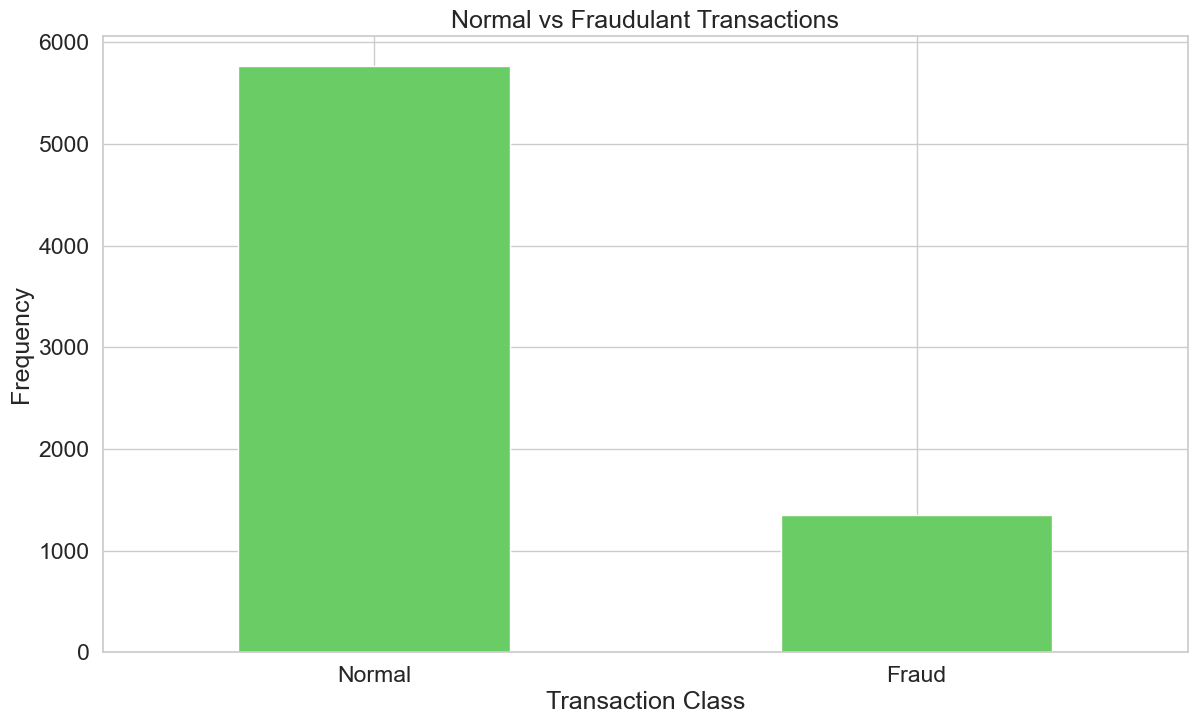

In [98]:
count_classes = pd.value_counts(df['FLAG'], sort = True)
count_classes.plot(kind = 'bar', rot=0, color="g")
plt.title("Normal vs Fraudulant Transactions")
plt.xticks(range(2), LABELS)
plt.xlabel("Transaction Class")
plt.ylabel("Frequency")

In [99]:
fraudsDF = df[df['FLAG'] == 1]
normalDF = df[df['FLAG'] == 0]

print(fraudsDF.shape)
print(normalDF.shape)

(1350, 51)
(5771, 51)


#### Препроцессинг

In [ ]:
y=df.pop('FLAG')

df=df.drop('Address',axis=1)

encoder = LabelEncoder()

df[' ERC20 most sent token type'] = encoder.fit_transform(df[' ERC20 most sent token type'])
df[' ERC20_most_rec_token_type'] = encoder.fit_transform(df[' ERC20_most_rec_token_type'])

scaler = StandardScaler()
df_sc = scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_sc, columns=df.columns)

df_scaled = pd.concat([df_scaled, y], axis=1)

In [ ]:
X_train, X_test = train_test_split(df_scaled, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.FLAG == 0]
X_train = X_train.drop(['FLAG'], axis=1)
y_test = X_test['FLAG']
X_test = X_test.drop(['FLAG'], axis=1)

X_train = X_train.values
X_test = X_test.values
y_test = y_test.values
print(y_test.size)

1425


#### Строим модель

In [102]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(49, 32),
            nn.Tanh(),
            nn.Linear(32, 16),
            nn.LeakyReLU(),
            )

        self.decoder = nn.Sequential(
           nn.Linear(16, 32),
           nn.Tanh(),
           nn.Linear(32, 49),
           nn.LeakyReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [103]:
model = Autoencoder().double()

In [104]:
num_epochs = 100
minibatch_size = 32
learning_rate = 1e-3

In [105]:
train_loader = data_utils.DataLoader(X_train, batch_size=minibatch_size, shuffle=True)
test_loader = data_utils.DataLoader(X_test, batch_size=1, shuffle=False)

In [106]:
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(
model.parameters(), lr=learning_rate, weight_decay=10e-05)

In [107]:
history = {}
history['train_loss'] = []
history['test_loss'] = []

In [ ]:
for epoch in range(num_epochs):
    h = np.array([])
    for data in train_loader:
        # ===================forward=====================
        output = model(data)
        loss = criterion(output, data)
        h = np.append(h, loss.item())

        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    mean_loss = np.mean(h)
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, mean_loss))
    history['train_loss'].append(mean_loss)


torch.save(model.state_dict(), './credit_card_model.pth')

epoch [1/100], loss:0.6540
epoch [2/100], loss:0.5351
epoch [3/100], loss:0.4877
epoch [4/100], loss:0.4669
epoch [5/100], loss:0.4518
epoch [6/100], loss:0.4401
epoch [7/100], loss:0.4275
epoch [8/100], loss:0.4165
epoch [9/100], loss:0.4053
epoch [10/100], loss:0.3949
epoch [11/100], loss:0.3852
epoch [12/100], loss:0.3758
epoch [13/100], loss:0.3666
epoch [14/100], loss:0.3579
epoch [15/100], loss:0.3504
epoch [16/100], loss:0.3445
epoch [17/100], loss:0.3367
epoch [18/100], loss:0.3300
epoch [19/100], loss:0.3250
epoch [20/100], loss:0.3171
epoch [21/100], loss:0.3115
epoch [22/100], loss:0.3063
epoch [23/100], loss:0.3012
epoch [24/100], loss:0.2962
epoch [25/100], loss:0.2921
epoch [26/100], loss:0.2878
epoch [27/100], loss:0.2835
epoch [28/100], loss:0.2789
epoch [29/100], loss:0.2750
epoch [30/100], loss:0.2735
epoch [31/100], loss:0.2679
epoch [32/100], loss:0.2651
epoch [33/100], loss:0.2608
epoch [34/100], loss:0.2570
epoch [35/100], loss:0.2543
epoch [36/100], loss:0.2506
e

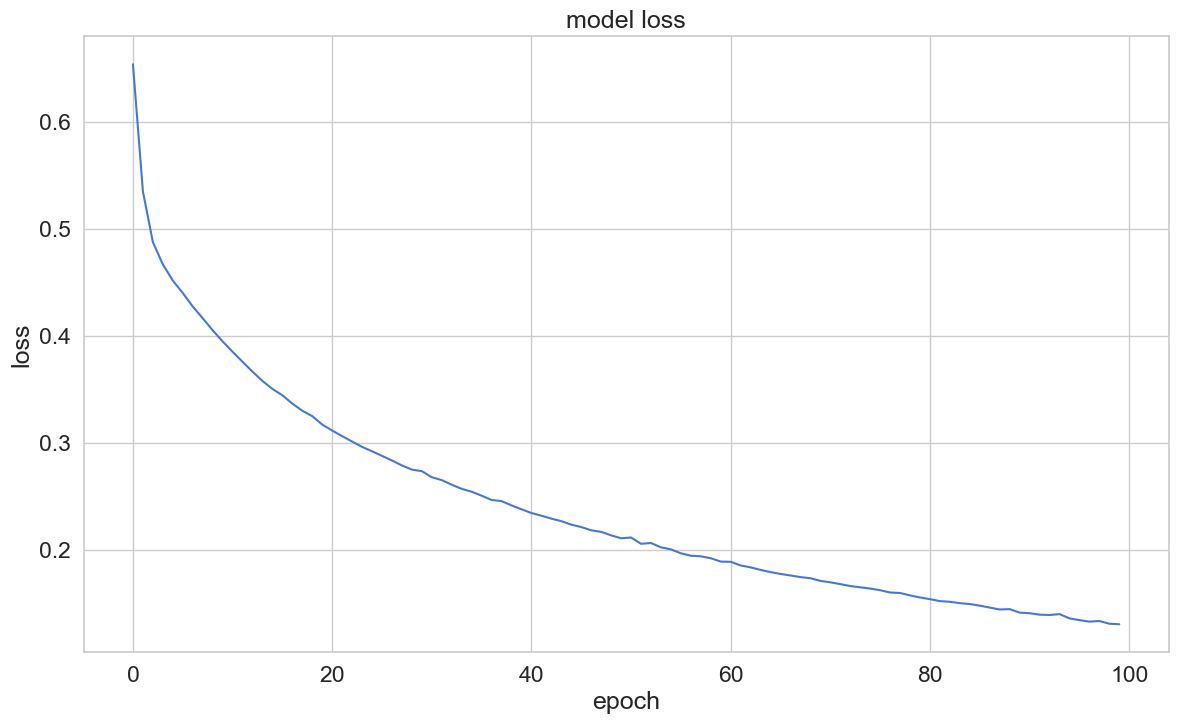

In [ ]:
plt.plot(history['train_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

#### Оценка

In [ ]:
pred_losses = {'pred_loss' : []}
model.eval()
with torch.no_grad():
    for data in test_loader:
        inputs = data
        outputs = model(inputs)
        loss = criterion(outputs, inputs).data.item()
        pred_losses['pred_loss'].append(loss)
reconstructionErrorDF = pd.DataFrame(pred_losses)
reconstructionErrorDF['FLAG'] = y_test

reconstructionErrorDF.describe()

,pred_loss,FLAG
count,1425.000000,1425.000000
mean,1.063175,0.177544
std,20.288023,0.382262
min,0.004959,0.000000
25%,0.018523,0.000000
50%,0.037796,0.000000
75%,0.080231,0.000000
max,581.442271,1.000000


#### ROC кривые

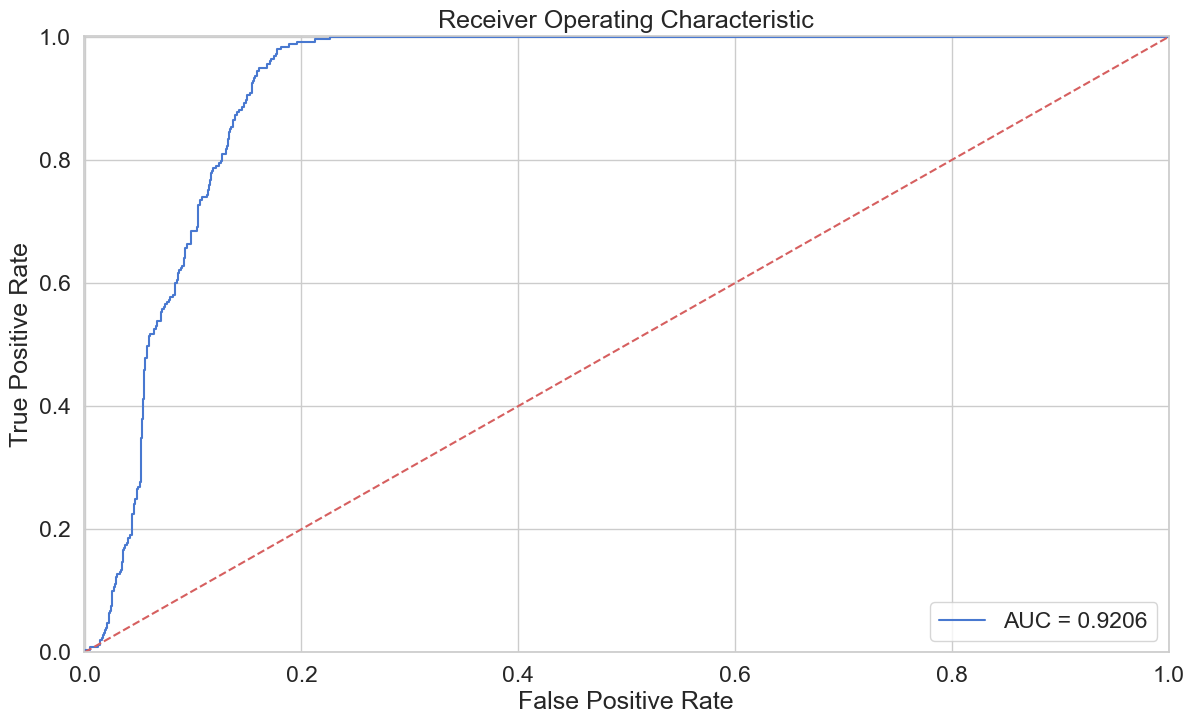

In [112]:
fpr, tpr, thresholds = roc_curve(reconstructionErrorDF.FLAG, reconstructionErrorDF.pred_loss)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Precision vs Recall

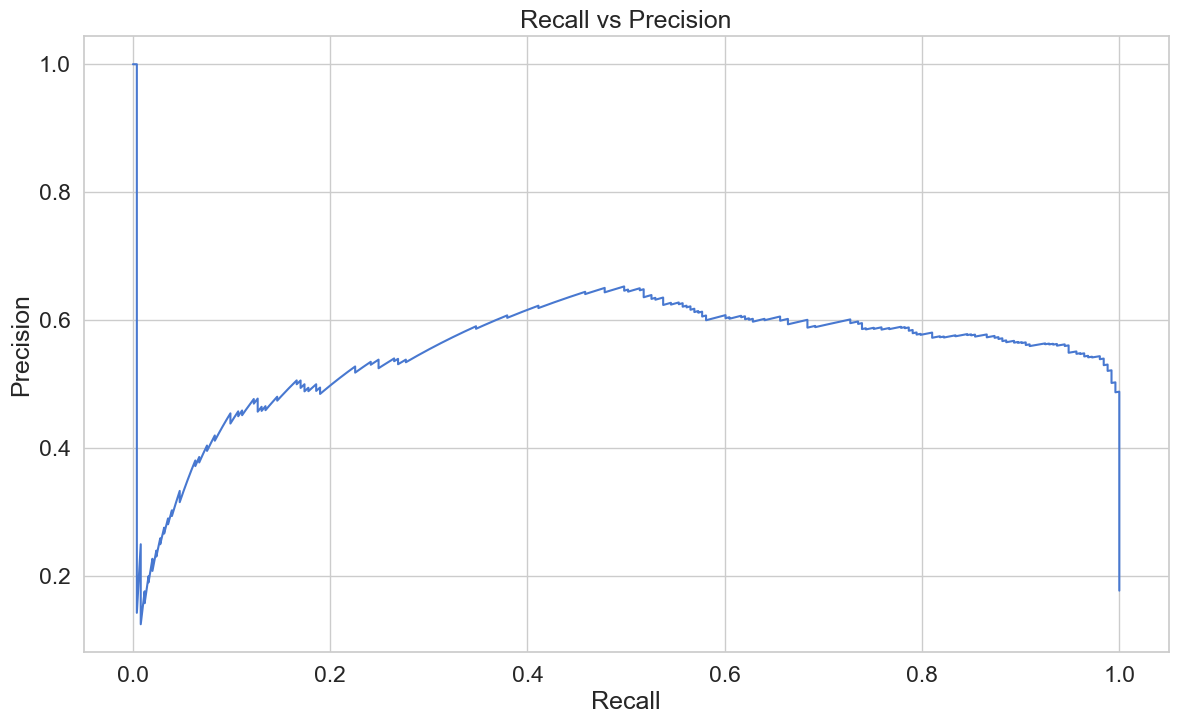

In [113]:
precision, recall, th = precision_recall_curve(reconstructionErrorDF.FLAG, reconstructionErrorDF.pred_loss)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

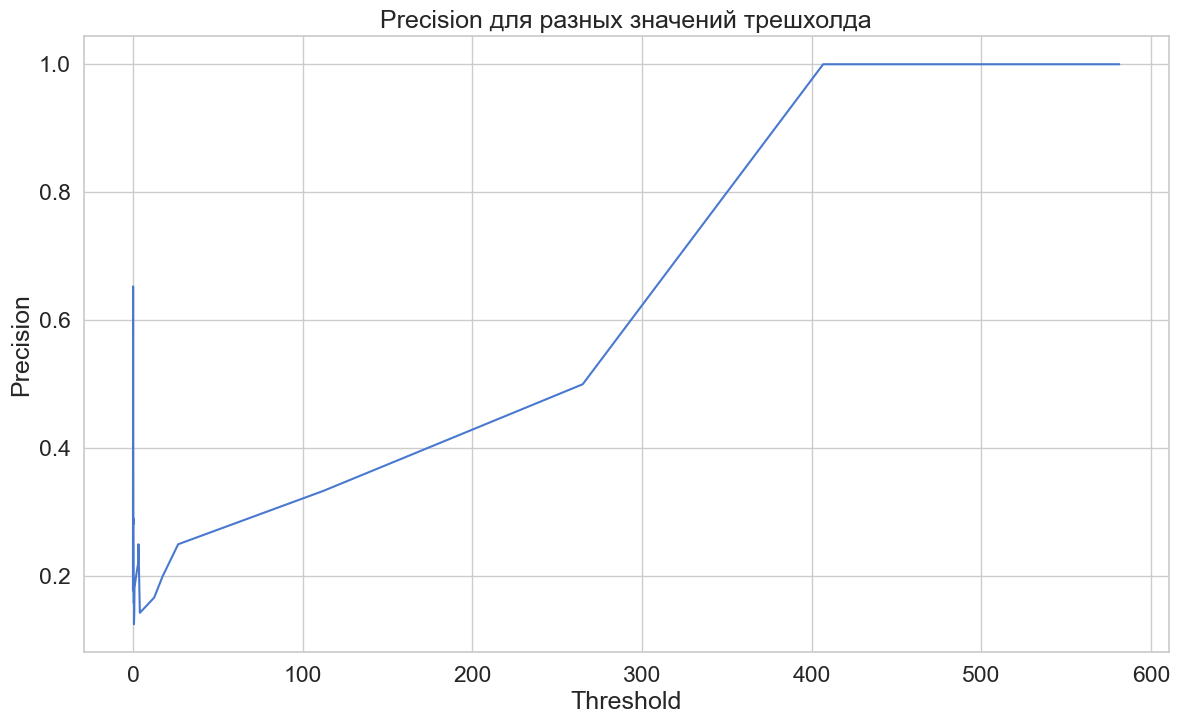

In [114]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision для разных значений трешхолда')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

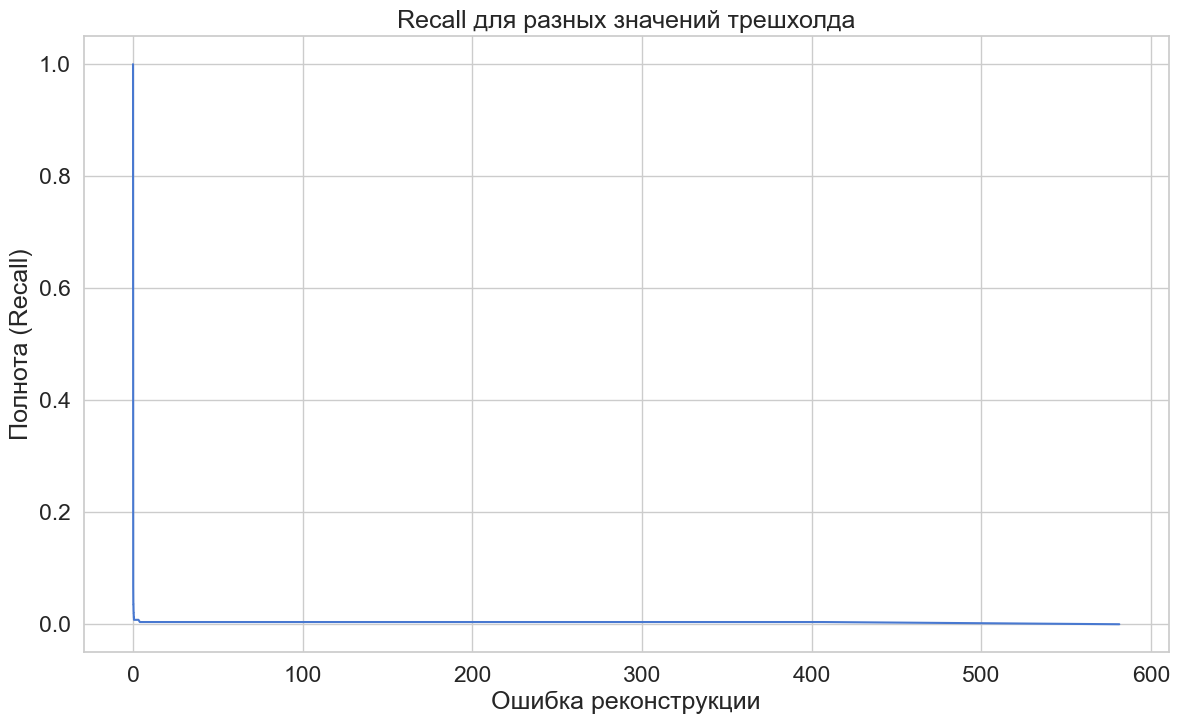

In [115]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall для разных значений трешхолда')
plt.xlabel('Ошибка реконструкции')
plt.ylabel('Полнота (Recall)')
plt.show()

#### Используем модель для предсказания

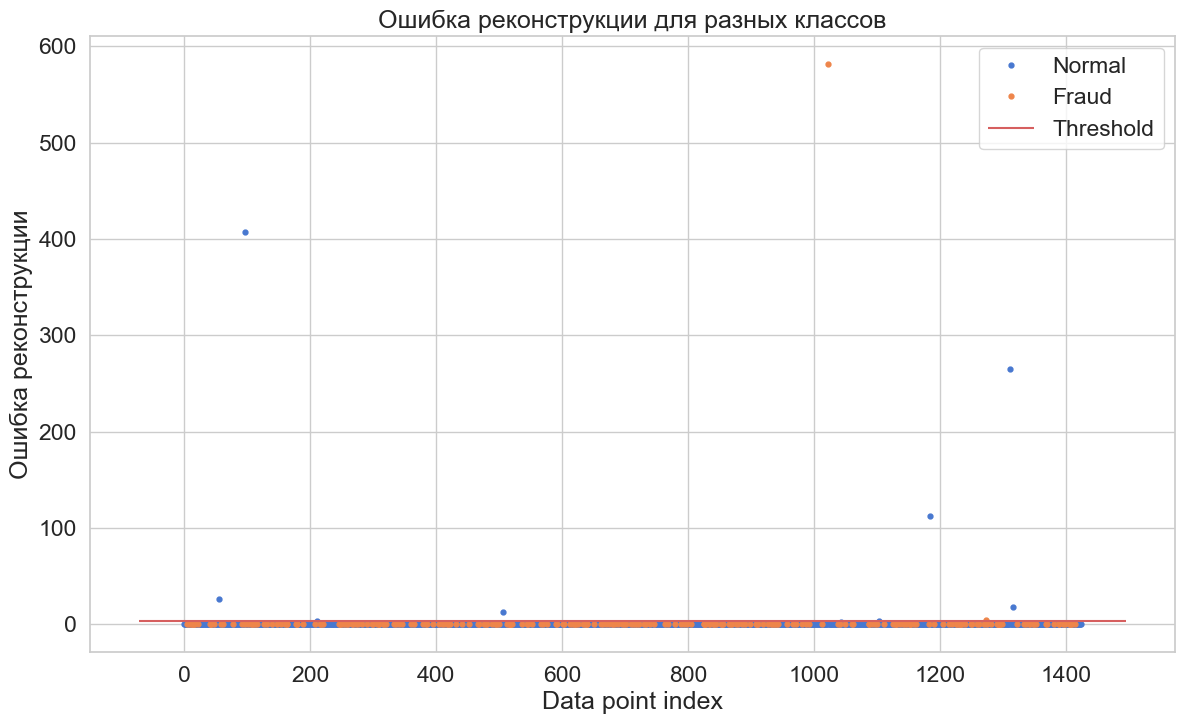

In [ ]:
threshold = 2.9

groups = reconstructionErrorDF.groupby('FLAG')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.pred_loss, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Ошибка реконструкции для разных классов")
plt.ylabel("Ошибка реконструкции")
plt.xlabel("Data point index")
plt.show()

/var/folders/dx/jw53r48d1tx21ndwg6f4_0jc0000gn/T/ipykernel_94526/2594247556.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap=plt.cm.get_cmap('Blues'));


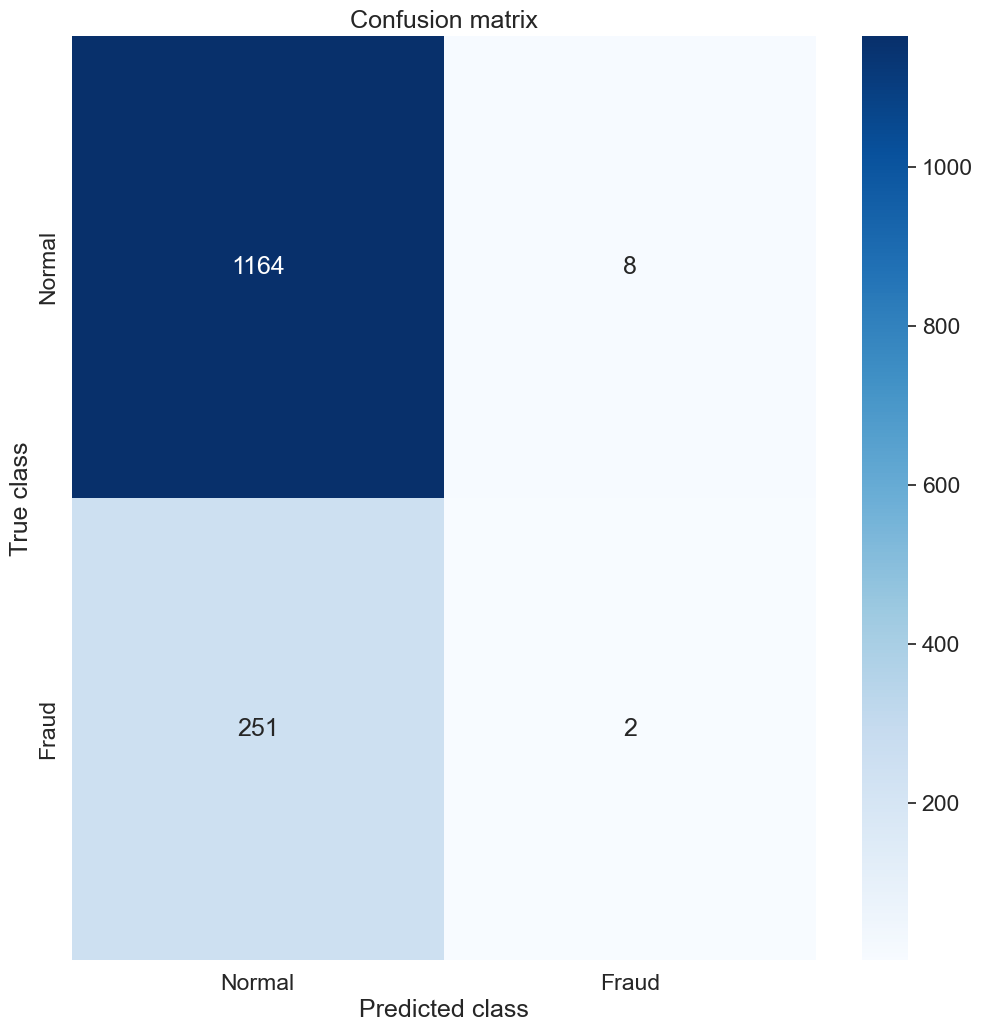

In [ ]:
y_pred = [1 if e > threshold else 0 for e in reconstructionErrorDF.pred_loss.values]
conf_matrix = confusion_matrix(reconstructionErrorDF.FLAG, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d",
            cmap=plt.cm.get_cmap('Blues'))
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()